<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/recommender_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sections as Input

In [1]:
pip install wandb

In [2]:
!wandb login

wandb: Currently logged in as: doris (use `wandb login --relogin` to force relogin)


In [3]:
import wandb

In [4]:
!pip uninstall gensim -y

Found existing installation: gensim 4.1.2
Uninstalling gensim-4.1.2:
  Successfully uninstalled gensim-4.1.2


In [5]:
!pip install gensim

  Using cached gensim-4.1.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)


In [6]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
from tqdm import tqdm 
from gensim.models.doc2vec import Doc2Vec
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from gensim.models import CoherenceModel
from gensim import corpora
from gensim import similarities
import pickle
import os

In [7]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [8]:
print(gensim.__version__)

4.1.2


In [9]:
!rm data.csv

# Configuration


In [10]:
chords_repeated = 'rep' 
chords_preprocessing = 'rootAndDegreesSimplified'

In [11]:
ngrams_for_input = [2]

In [12]:
input_files = {
    'sections': {
        'rep': {
            # M7 and 6 reduced to major triad, m7 reduced to m, dominant 7, m7b5, diminished, and all (b5) left as they are.
            'rootAndDegreesPlus': '17djlZRWFSUCviOxRTOF-nwbbZqU5gUP9',
            'rootAndDegrees7': '1lQTBMYk7Ui_mbOopUTjOs4MV_4c1a8bO',
            'rootAndDegreesSimplified': '1lVm6r0T3i1hbyZqPJXNKf90uh14MOKkb'
        },
    },
    'tunes': {
        'rep': {
            'rootAndDegreesPlus': '',
            'rootAndDegrees7': '',
            'rootAndDegreesSimplified': '',
        },
        'norep': {
            'rootAndDegreesPlus': '',
            'rootAndDegrees7': '',
            'rootAndDegreesSimplified': '',
        }
    }
}

In [13]:
tunes_eval_list = [
  "Sweet Sue, Just You",
  "These Foolish Things", 
  "Blue Moon",
  "All Of Me",
  "All God's Chillun Got Rhythm",
  "I Got Rhythm",
  "Bye Bye Blackbird",
  "Old Fashioned Love",
  "Dinah",
  "Honeysuckle Rose",
  "Misty",
  "We'll Be Together Again",
  "East Of The Sun",
  "Sophisticated Lady",
  "Perdido",
  "Naima",
  "Call Me Irresponsible",
  "Corcovado",
  "Footprints",
  "Giant Steps",
  "But Beautiful",
  "Rockin' Chair",
  "Blood Count",
  "After You've Gone",
]

tunes_eval_list = sorted(tunes_eval_list)
tunes_eval_list

["After You've Gone",
 "All God's Chillun Got Rhythm",
 'All Of Me',
 'Blood Count',
 'Blue Moon',
 'But Beautiful',
 'Bye Bye Blackbird',
 'Call Me Irresponsible',
 'Corcovado',
 'Dinah',
 'East Of The Sun',
 'Footprints',
 'Giant Steps',
 'Honeysuckle Rose',
 'I Got Rhythm',
 'Misty',
 'Naima',
 'Old Fashioned Love',
 'Perdido',
 "Rockin' Chair",
 'Sophisticated Lady',
 'Sweet Sue, Just You',
 'These Foolish Things',
 "We'll Be Together Again"]

# Initialization

## Download the Data

In [14]:
input_data = input_files['sections'][chords_repeated][chords_preprocessing]

input_path = f"https://docs.google.com/uc?export=download&id={input_data}"
data_file_name = 'data.csv'


In [15]:
input_path

'https://docs.google.com/uc?export=download&id=1lVm6r0T3i1hbyZqPJXNKf90uh14MOKkb'

In [16]:
!wget --no-check-certificate "$input_path" -O "$data_file_name"

--2021-11-22 20:41:06--  https://docs.google.com/uc?export=download&id=1lVm6r0T3i1hbyZqPJXNKf90uh14MOKkb
Resolving docs.google.com (docs.google.com)... 142.250.136.113, 142.250.136.102, 142.250.136.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.136.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3em2h3hv4jm7jjro9ehuscn0e62ogpkk/1637613600000/14329102864480165501/*/1lVm6r0T3i1hbyZqPJXNKf90uh14MOKkb?e=download [following]
--2021-11-22 20:41:06--  https://doc-0c-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3em2h3hv4jm7jjro9ehuscn0e62ogpkk/1637613600000/14329102864480165501/*/1lVm6r0T3i1hbyZqPJXNKf90uh14MOKkb?e=download
Resolving doc-0c-4c-docs.googleusercontent.com (doc-0c-4c-docs.googleusercontent.com)... 173.194.197.132, 2607:f8b0:4001:c1b::84
Connecting to doc-0c-4c-docs.googleusercontent.com (doc-0c

### Read Chords Input Data

In [17]:
df = pd.read_csv(data_file_name, sep='\t', index_col="id")
df = df.reset_index()
df.head(5)

,id,file_name,title,tune_mode,tune_id,section_name,section_id,chords
0,0,dataset/jazz1350/26-2.xml,26-2,major,0,A,1,CM7 Eb7 G#M7 B7 EM7 G7 Gm7 C7 FM7 G#7 C#M7 E7 ...
1,1,dataset/jazz1350/26-2.xml,26-2,major,0,A,2,CM7 Eb7 G#M7 B7 EM7 G7 Gm7 C7 FM7 Eb7 G#M7 B7 ...
2,2,dataset/jazz1350/26-2.xml,26-2,major,0,B,3,Gm7 C7 Bm7 E7 AM7 C7 FM7 Bbm7 Eb7 G#M7 Dm7 G7
3,3,dataset/jazz1350/26-2.xml,26-2,major,0,A,4,CM7 Eb7 G#M7 B7 EM7 G7 Gm7 C7 FM7 Eb7 G#M7 B7 ...
4,4,dataset/jazz1350/500 Miles High.xml,500 Miles High,minor,1,NaN,0,Am7 Am7 Cm7 Cm7 EbM7 EbM7 Em7b5 A7 Dm7 Dm7 Bm7...


### Meta Data

In [18]:
titles = df.loc[:, ['id', 'tune_id', 'section_id', 'section_name', 'title', 'tune_mode']]
titles[:5]

,id,tune_id,section_id,section_name,title,tune_mode
0,0,0,1,A,26-2,major
1,1,0,2,A,26-2,major
2,2,0,3,B,26-2,major
3,3,0,4,A,26-2,major
4,4,1,0,NaN,500 Miles High,minor


In [19]:
titles_dict = titles.to_dict()

sectionid_to_title = titles_dict['title']
sectionid_to_titleid = titles_dict['tune_id']


In [20]:
tunes = df.loc[:, ['tune_id', 'title']].drop_duplicates()
tunes = tunes.set_index('tune_id').to_dict()
titleid_to_title = tunes['title']

In [21]:
titles_rows = titles.to_dict(orient='records')
sectionid_to_section = []
for i, row in enumerate(titles_rows):
  name = f"{row['title']}, section{row['section_id']} ({row['section_name']})"
  sectionid_to_section.append(name)
  

In [22]:
title_to_sectionid = {}

for row in titles.iterrows():
  title = row[1]['title']
  if title not in title_to_sectionid:
    title_to_sectionid[title] = [row[1]['id']]
  else:
    title_to_sectionid[title].append(row[1]['id'])

## Initialization for wandb variables

In [23]:
recommender_results_cols = ['reference', 'id', 'method', 'similar', 'score_div_max', 'score']
recommender_results = pd.DataFrame(columns=recommender_results_cols)

In [24]:
lsi_config = {
    'num_topics': 200,
}

In [25]:
doc2vec_config = {
    'general': {
        'chords_preprocessing': chords_preprocessing,
        'chords_repeated': chords_repeated,
        'document_tags': 'SectionsTunes',
    },
    'model': {
        'dm': 1,
        'vector_size': 100,
        'window': 4,
        'epochs': 40,
        #'workers': 1,
        'min_count': 1,
        'negative': 10,
        'sample': 0.001,
        'seed': 42
    }
}

In [26]:
wandb.init(
      # Set entity to specify your username or team name
      # ex: entity="carey",
      # Set the project where this run will be logged
      project="jazztunes", 
      
      # Track hyperparameters and run metadata
      config={
          "input_data": "https://docs.google.com/uc?export=download&id=17djlZRWFSUCviOxRTOF-nwbbZqU5gUP9",
          "ngrams_input": ngrams_for_input,
          "comparison": "sections",
          "lsi": lsi_config,
          "doc2vec": doc2vec_config
      }
  )

wandb: Currently logged in as: doris (use `wandb login --relogin` to force relogin)


In [27]:
artifact = wandb.Artifact('input_data', type='dataset')
artifact.add_file('data.csv')
wandb.log_artifact(artifact)

## Helpers functions

In [28]:
def ngrams(tokens, n=2, sep='-'):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [29]:
def raw_chords_to_df(tunes):
  tunes_chords = [item for tune in tunes for item in tune]
  counts = Counter(tunes_chords)
  df = pd.DataFrame(counts.items(),
                    columns=['chord', 'count']).sort_values(by='count', ascending=False)

  return df

# Data Preparation

In [30]:
lines = df.loc[:, 'chords'].tolist()
data = [line.split(' ') for line in lines]

In [31]:
processed_corpus = []
for line in data:
  tune_n = []
  for n in ngrams_for_input:
    tune_n.extend(ngrams(line, n=n))
  processed_corpus.append(tune_n)

for line in processed_corpus[:5]:
  print(line)

['CM7-Eb7', 'Eb7-G#M7', 'G#M7-B7', 'B7-EM7', 'EM7-G7', 'G7-Gm7', 'Gm7-C7', 'C7-FM7', 'FM7-G#7', 'G#7-C#M7', 'C#M7-E7', 'E7-Am7', 'Am7-D7', 'D7-Dm7', 'Dm7-G7']
['CM7-Eb7', 'Eb7-G#M7', 'G#M7-B7', 'B7-EM7', 'EM7-G7', 'G7-Gm7', 'Gm7-C7', 'C7-FM7', 'FM7-Eb7', 'Eb7-G#M7', 'G#M7-B7', 'B7-EM7', 'EM7-G7', 'G7-CM7']
['Gm7-C7', 'C7-Bm7', 'Bm7-E7', 'E7-AM7', 'AM7-C7', 'C7-FM7', 'FM7-Bbm7', 'Bbm7-Eb7', 'Eb7-G#M7', 'G#M7-Dm7', 'Dm7-G7']
['CM7-Eb7', 'Eb7-G#M7', 'G#M7-B7', 'B7-EM7', 'EM7-G7', 'G7-Gm7', 'Gm7-C7', 'C7-FM7', 'FM7-Eb7', 'Eb7-G#M7', 'G#M7-B7', 'B7-EM7', 'EM7-G7', 'G7-CM7']
['Am7-Am7', 'Am7-Cm7', 'Cm7-Cm7', 'Cm7-EbM7', 'EbM7-EbM7', 'EbM7-Em7b5', 'Em7b5-A7', 'A7-Dm7', 'Dm7-Dm7', 'Dm7-Bm7b5', 'Bm7b5-Bm7b5', 'Bm7b5-Bbm7', 'Bbm7-Bbm7', 'Bbm7-Fm7', 'Fm7-Fm7', 'Fm7-E7', 'E7-E7', 'E7-Fm7', 'Fm7-Fm7', 'Fm7-C#M7', 'C#M7-C#M7', 'C#M7-Fm7', 'Fm7-Fm7', 'Fm7-C#M7', 'C#M7-C#M7']


#### Corpus Overview

In [32]:
tokens = [item for l in processed_corpus for item in l]
total_tokens = len(tokens)
vocab_size = len(set(tokens))
vocab_prop = 100*vocab_size/total_tokens

print(f"Total Number of tokens: {total_tokens}")
print(f"Size of vocabulary: {vocab_size}")
print(f"Proportion of vocabulary in corpus: {vocab_prop:.02f}%")

Total Number of tokens: 77231
Size of vocabulary: 3750
Proportion of vocabulary in corpus: 4.86%


In [33]:
df_chords = raw_chords_to_df(processed_corpus)
df_chords

,chord,count
14,Dm7-G7,5136
61,G7-C,2024
465,C-C,1916
31,A7-Dm7,1823
16,G7-CM7,1760
...,...,...
2500,G#M7-Cm7,1
2498,AM7-Ebdim7,1
2496,Gm7-D,1
2491,Edim7-G7,1


In [34]:
df_chords = pd.DataFrame.from_dict(df_chords)
df_chords.sort_values(by=['count'], ascending=False, inplace=True)
df_chords_top = df_chords.query('count > 100')

fig = px.bar(df_chords_top, x='chord', y='count', log_y=True)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

2021-11-22 20:41:13,546 : INFO : NumExpr defaulting to 2 threads.


Plot Distribution accoring to Zipf's Law

source: https://stats.stackexchange.com/questions/331219/characterizing-fitting-word-count-data-into-zipf-power-law-lognormal

In [35]:
from collections import Counter

counter_of_words = df_chords.set_index('chord').to_dict(orient='dict')
counter_of_words = Counter(counter_of_words['count'])
counter_of_counts = Counter(counter_of_words.values())

word_counts = np.array(list(counter_of_counts.keys()))
freq_of_word_counts = np.array(list(counter_of_counts.values()))

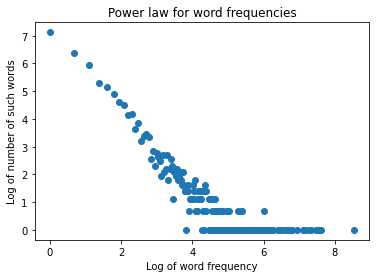

In [36]:
plt.scatter(np.log(word_counts), np.log(freq_of_word_counts))
plt.xlabel('Log of word frequency')
plt.ylabel('Log of number of such words')
plt.title('Power law for word frequencies')

plt.savefig('plot.png')

In [37]:
def neg_zipf_likelihood(s):
    n = sum(freq_of_word_counts)
    # for each word count, find the probability that a random word has such word count
    probas = word_counts ** (-s) / np.sum(np.arange(1, n+1) **(-s))
    log_likelihood = sum(np.log(probas) * word_counts)
    return -log_likelihood

from scipy.optimize import minimize_scalar
s_best = minimize_scalar(neg_zipf_likelihood, [0.1, 3.0] )
print(s_best.x)

0.471675518523981


In [38]:
wandb.log(
    {"corpus": {
            "total_tokens": total_tokens,
            "vocab_size": vocab_size,
            "vocab_proportion_in_corpus": vocab_prop,
            "zipf_plot": wandb.Image('plot.png'),
            }
     }
)

# TF-IDF

In [39]:
dictionary = corpora.Dictionary(processed_corpus)
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
tfidf = TfidfModel(bow_corpus)

2021-11-22 20:41:14,795 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-22 20:41:14,946 : INFO : built Dictionary(3750 unique tokens: ['Am7-D7', 'B7-EM7', 'C#M7-E7', 'C7-FM7', 'CM7-Eb7']...) from 5391 documents (total 77231 corpus positions)
2021-11-22 20:41:14,948 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(3750 unique tokens: ['Am7-D7', 'B7-EM7', 'C#M7-E7', 'C7-FM7', 'CM7-Eb7']...) from 5391 documents (total 77231 corpus positions)", 'datetime': '2021-11-22T20:41:14.948245', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-11-22 20:41:15,035 : INFO : collecting document frequencies
2021-11-22 20:41:15,037 : INFO : PROGRESS: processing document #0
2021-11-22 20:41:15,074 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 5391 documents and 3750 features (58273 matrix non-zeros)', 'datetime': '2021-11-2

In [40]:
# dictionary.token2id

In [41]:
!rm -R index
!mkdir index

In [42]:
# Note: SparseMatrixSimilarity crashes due to lacking memory
#from gensim.test.utils import get_tmpfile
#index_tmpfile = get_tmpfile("index")
#index_tfidf = similarities.Similarity('/content/index/index_tfidf', bow_corpus, num_features=len(dictionary))

index_tfidf = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features = len(dictionary))

2021-11-22 20:41:15,385 : INFO : creating sparse index
2021-11-22 20:41:15,389 : INFO : creating sparse matrix from corpus
2021-11-22 20:41:15,392 : INFO : PROGRESS: at document #0
2021-11-22 20:41:15,874 : INFO : created <5391x3750 sparse matrix of type '<class 'numpy.float32'>'
	with 58273 stored elements in Compressed Sparse Row format>


In [43]:
tfidf.save('/content/index/tfidf.model')  # save model
index_tfidf.save('/content/index/tfidf.index') #save index

2021-11-22 20:41:15,892 : INFO : TfidfModel lifecycle event {'fname_or_handle': '/content/index/tfidf.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-22T20:41:15.892807', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-22 20:41:15,912 : INFO : saved /content/index/tfidf.model
2021-11-22 20:41:15,915 : INFO : SparseMatrixSimilarity lifecycle event {'fname_or_handle': '/content/index/tfidf.index', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-22T20:41:15.915544', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-22 20:41:15,920 : INFO : saved /content/index/tfidf.index


## Test for single tunes

In [44]:
def get_sim_scores(tunes, index, model):

    df_sim = pd.DataFrame(columns=['reference_title',
                                  'similar_title',
                                  'ref_section', 
                                  'similar_section', 
                                  'score', 
                                  ])

    for tune in tunes:
      print()
      print("-"*50)
      for s1 in title_to_sectionid[tune]:
      
          query = processed_corpus[s1]
          query_bow = dictionary.doc2bow(query)

          # perform a similarity query against the corpus
          similarities = index[model[query_bow]]
          sims = sorted(enumerate(similarities), key=lambda item: -item[1])
          
          print(s1, sectionid_to_section[s1])
          n = 0
          for s2, s2_score in sims:
            
            # store the top N best results
            if n > 40:
                break
            # don't count self-similarity between sections of the same tune
            if s2 not in title_to_sectionid[tune]:
                n += 1
            
                # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")

                df_sim.loc[len(df_sim)] = [tune,
                                sectionid_to_title[s2],
                                sectionid_to_section[s1], 
                                sectionid_to_section[s2], 
                                s2_score, 
                                ]
    return df_sim

In [45]:
%%time
df_sim = get_sim_scores(tunes_eval_list, index_tfidf, tfidf)
df_tfidf = df_sim[:]


--------------------------------------------------
125 After You've Gone, section1 (A)
126 After You've Gone, section2 (B)
127 After You've Gone, section3 (A)
128 After You've Gone, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
474 Blood Count, section1 (A)
475 Blood Count, section2 (A)
476 Blood Count, section3 (B)
477 Blood Count, section4 (A)
478 Blood Count, section5 (C)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

---------------------------------

In [46]:
import plotly.express as px
fig = px.histogram(df_sim, x="score", nbins=50, title='Scores for TF-IDF')
fig.show()

In [47]:
wandb.log({"scores_hist": fig})

In [48]:
def recommend_tune(df, tune_name):

  df_tune = df.query(f'reference_title == "{tune_name}"')
  ff = df_tune.iloc[:]

  # get the maximum similarity score for each section and store in new column
  ff['max'] = ff.groupby('ref_section')['score'].transform('max')

  # scale the score with the maxmum value of each section
  ff['score_div_max'] = ff['score'] / ff['max']

  # consider only the top N tunes for each group
  ff = ff.sort_values(['ref_section', 'score_div_max'], ascending=[True, False])
  result = ff.groupby('ref_section').head(30)
  
  # if multiple rows from the same similar tune, keep only the similar_title with the highest score_div_max
  result = result.groupby('similar_title').max('score_div_max').sort_values('score_div_max', ascending=False)
  
  # add the name of the reference tune
  result['reference'] = tune_name
  result = result.reset_index()
  result = result.loc[:, ['reference', 'similar_title', 'score', 'max', 'score_div_max']]
  result = result.reset_index()
  return result, ff

In [49]:
result, details = recommend_tune(df_sim, "These Foolish Things")
result.head(5)

,index,reference,similar_title,score,max,score_div_max
0,0,These Foolish Things,More Than You Know,0.677200,0.677200,1.000000
1,1,These Foolish Things,Too Young To Go Steady,0.751212,0.751212,1.000000
2,2,These Foolish Things,I Won't Dance,0.704622,0.751212,1.000000
3,3,These Foolish Things,I Like The Likes Of You,0.736057,0.751212,1.000000
4,4,These Foolish Things,Emily,0.698766,0.751212,0.991689


Copy results into a dataframe for later logging to W&B

In [50]:
dd = pd.DataFrame(columns = recommender_results_cols)

for tune in tunes_eval_list:
  result, details = recommend_tune(df_sim, tune)
  dd['id'] = result['index']
  dd['method'] = 'tfidf'
  dd['reference'] = tune
  dd['similar'] = result['similar_title']
  dd['score_div_max'] = result['score_div_max']
  dd['score'] = result['score']

recommender_results = recommender_results.append(dd)

Store TF-IDF Model to W&B

In [51]:
model_artifact = wandb.Artifact(
    "tfidf-model", 
    type="model",
    description="TF-IDF Model",
    metadata="")

model_artifact.add_file("/content/index/tfidf.model")
model_artifact.add_file("/content/index/tfidf.index")
wandb.log_artifact(model_artifact)

# LSA (Latent Semantic Analysis), aka LSI (Latent Semantic Index) 

In [52]:
from collections import defaultdict

In [53]:
num_topics = lsi_config['num_topics']

# remove words that appear only once
frequency = defaultdict(int)
for text in processed_corpus:
    for token in text:
        frequency[token] += 1

data = [[token for token in text if frequency[token] > 1] for text in processed_corpus]
dictionary = corpora.Dictionary(data)

# doc2bow counts the number of occurences of each distinct word,
# converts the word to its integer word id and returns the result
# as a sparse vector

bow_corpus = [dictionary.doc2bow(text) for text in data]
lsi = LsiModel(bow_corpus, id2word=dictionary, num_topics=num_topics)  # num_topics can be maximum the size of the number of unique tokens

2021-11-22 20:41:33,298 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-22 20:41:33,455 : INFO : built Dictionary(2505 unique tokens: ['Am7-D7', 'B7-EM7', 'C#M7-E7', 'C7-FM7', 'CM7-Eb7']...) from 5391 documents (total 75986 corpus positions)
2021-11-22 20:41:33,459 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(2505 unique tokens: ['Am7-D7', 'B7-EM7', 'C#M7-E7', 'C7-FM7', 'CM7-Eb7']...) from 5391 documents (total 75986 corpus positions)", 'datetime': '2021-11-22T20:41:33.459331', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-11-22 20:41:33,544 : INFO : using serial LSI version on this node
2021-11-22 20:41:33,546 : INFO : updating model with new documents
2021-11-22 20:41:33,553 : INFO : preparing a new chunk of documents
2021-11-22 20:41:33,589 : INFO : using 100 extra samples and 2 power iterations
2021-11-22 20:41:33,596

In [54]:
#index_lsi = similarities.Similarity('/content/index/index_lsi', bow_corpus, num_features=len(dictionary))

In [55]:
index_lsi = similarities.SparseMatrixSimilarity(lsi[bow_corpus], num_features = len(dictionary))
#index_lsi = similarities.MatrixSimilarity(lsi[bow_corpus])  # transform corpus to LSI space and index it


2021-11-22 20:41:34,590 : INFO : creating sparse index
2021-11-22 20:41:34,596 : INFO : creating sparse matrix from corpus
2021-11-22 20:41:34,605 : INFO : PROGRESS: at document #0
2021-11-22 20:41:36,357 : INFO : created <5391x2505 sparse matrix of type '<class 'numpy.float32'>'
	with 1078199 stored elements in Compressed Sparse Row format>


In [56]:
lsi.save('/content/index/lsi.model')
index_lsi.save('/content/index/lsi_matrixsim.index')


2021-11-22 20:41:36,376 : INFO : Projection lifecycle event {'fname_or_handle': '/content/index/lsi.model.projection', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-22T20:41:36.376586', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-22 20:41:36,385 : INFO : saved /content/index/lsi.model.projection
2021-11-22 20:41:36,388 : INFO : LsiModel lifecycle event {'fname_or_handle': '/content/index/lsi.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': ['projection', 'dispatcher'], 'datetime': '2021-11-22T20:41:36.388424', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-22 20:41:36,391 : INFO : not storing attribute projection
2021-11-22 20:41:36,393 : INFO : not storing attribute dispatch

In [57]:
!ls -la /content/index

total 13032
drwxr-xr-x 2 root root    4096 Nov 22 20:41 .
drwxr-xr-x 1 root root    4096 Nov 22 20:41 ..
-rw-r--r-- 1 root root 8648061 Nov 22 20:41 lsi_matrixsim.index
-rw-r--r-- 1 root root   77638 Nov 22 20:41 lsi.model
-rw-r--r-- 1 root root 4010291 Nov 22 20:41 lsi.model.projection
-rw-r--r-- 1 root root  488641 Nov 22 20:41 tfidf.index
-rw-r--r-- 1 root root  101754 Nov 22 20:41 tfidf.model


### Test for single tunes

In [58]:
%%time
df_sim = get_sim_scores(tunes_eval_list, index=index_lsi, model=lsi)
df_lsi = df_sim[:]


--------------------------------------------------
125 After You've Gone, section1 (A)
126 After You've Gone, section2 (B)
127 After You've Gone, section3 (A)
128 After You've Gone, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
474 Blood Count, section1 (A)
475 Blood Count, section2 (A)
476 Blood Count, section3 (B)
477 Blood Count, section4 (A)
478 Blood Count, section5 (C)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

---------------------------------

In [59]:
import plotly.express as px
fig = px.histogram(df_sim, x="score", nbins=50, title='LSI Scores')
fig.show()

In [60]:
wandb.log({"scores_hist": fig})

In [61]:
result, details = recommend_tune(df_sim, 'These Foolish Things')
result.head(30)

,index,reference,similar_title,score,max,score_div_max
0,0,These Foolish Things,I Like The Likes Of You,0.851162,0.851162,1.000000
1,1,These Foolish Things,I Won't Dance,0.846998,0.851162,1.000000
2,2,These Foolish Things,Isn't It A Pity,0.868415,0.868415,1.000000
3,3,These Foolish Things,"Party's Over, The",0.844050,0.851162,0.991644
4,4,These Foolish Things,People,0.830969,0.851162,0.981076
5,5,These Foolish Things,"Touch Of Your Lips, The",0.814827,0.851162,0.962018
6,6,These Foolish Things,Don't Be That Way,0.813617,0.851162,0.960590
7,7,These Foolish Things,Heart And Soul,0.810102,0.851162,0.956439
8,8,These Foolish Things,Dinah,0.809738,0.851162,0.951332
9,9,These Foolish Things,They All Laughed,0.805729,0.846998,0.951277


In [62]:
dd = pd.DataFrame(columns = recommender_results_cols)

for tune in tunes_eval_list:
  result, details = recommend_tune(df_sim, tune)
  dd['id'] = result['index']
  dd['reference'] = tune
  dd['method'] = 'lsi'
  dd['similar'] = result['similar_title']
  dd['score_div_max'] = result['score_div_max']
  dd['score'] = result['score']

recommender_results = recommender_results.append(dd)

## Determine Number of Topics for LSI Model

This sample comes from Datacamp: 

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python


What is the best way to determine k (number of topics) in topic modeling? Identify the optimum number of topics in the given corpus text is a challenging task. We can use the following options for determining the optimum number of topics:

* One way to determine the optimum number of topics is to consider each topic as a cluster and find out the effectiveness of a cluster using the Silhouette coefficient.
* Topic coherence measure is a realistic measure for identifying the number of topics.

Topic Coherence measure is a widely used metric to evaluate topic models. It uses the latent variable models. Each generated topic has a list of words. In topic coherence measure, you will find average/median of pairwise word similarity scores of the words in a topic. The high value of topic coherence score model will be considered as a good topic model. 

In [63]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix

In [64]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [65]:
def plot_graph(doc_clean,start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [66]:
# evaluate a good number of topics for the LSI Model. This takes some time.

if False:

  start, stop, step = 1, 500, 10
  plot_graph(data, start, stop, step)

For unigrams, the best number of topics seems to be around 20.

For unigrams plus bigrams, the coherence score drops down until 100 and then continuously rises until 500 and continues to rise. Same for bigrams-only.

Store Model to W&B

In [67]:
model_artifact = wandb.Artifact(
    "trained-model", 
    type="model",
    description="LSI model",
    metadata="")

model_artifact.add_file("/content/index/lsi.model")
model_artifact.add_file("/content/index/lsi_matrixsim.index")
model_artifact.add_file("/content/index/lsi.model.projection")
wandb.log_artifact(model_artifact)

# Doc2Vec

In [68]:
def get_tagged_documents(corpus, tags=None):
  if tags == 'SectionsTunes':
    print('Tagging input data with both section and tune information.')
  else:
    print('Tagging input data with section informaiton only.')
    
  for i, tokens in enumerate(corpus):
    if tags == 'SectionsTunes':
      yield gensim.models.doc2vec.TaggedDocument(tokens, [i, f'titleid_{sectionid_to_titleid[i]}'])
    else:
      yield gensim.models.doc2vec.TaggedDocument(tokens, [i])  # diatonic chord distance is a bit better

In [69]:
train_corpus = list(get_tagged_documents(processed_corpus, doc2vec_config['general']['document_tags']))
train_corpus[1000]

Tagging input data with both section and tune information.


TaggedDocument(words=['CM7-Am7', 'Am7-Dm7', 'Dm7-G7', 'G7-CM7', 'CM7-FM7', 'FM7-C', 'C-Am7', 'Am7-Dm7', 'Dm7-G7', 'G7-C6', 'C6-Dm7', 'Dm7-G7'], tags=[1000, 'titleid_308'])

In [70]:
import multiprocessing

print(f"CPU Count: {multiprocessing.cpu_count()}")
print(f"Config:")
print(doc2vec_config['model'])

model = Doc2Vec(train_corpus,
                **doc2vec_config['model']
                )

2021-11-22 20:41:55,027 : INFO : collecting all words and their counts
2021-11-22 20:41:55,029 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-11-22 20:41:55,090 : INFO : collected 3750 word types and 7200 unique tags from a corpus of 5391 examples and 77231 words
2021-11-22 20:41:55,091 : INFO : Creating a fresh vocabulary
2021-11-22 20:41:55,111 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 3750 unique words (100.0%% of original 3750, drops 0)', 'datetime': '2021-11-22T20:41:55.111815', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-11-22 20:41:55,113 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 77231 word corpus (100.0%% of original 77231, drops 0)', 'datetime': '2021-11-22T20:41:55.113544', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GC

CPU Count: 2
Config:
{'dm': 1, 'vector_size': 100, 'window': 4, 'epochs': 40, 'min_count': 1, 'negative': 10, 'sample': 0.001, 'seed': 42}


2021-11-22 20:41:55,211 : INFO : estimated required memory for 3750 words and 100 dimensions: 9195000 bytes
2021-11-22 20:41:55,218 : INFO : resetting layer weights
2021-11-22 20:41:55,229 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 3750 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=10 window=4 shrink_windows=True', 'datetime': '2021-11-22T20:41:55.229559', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2021-11-22 20:41:55,928 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-22 20:41:56,022 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-22 20:41:56,032 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-22 20:41:56,034 : INFO : EPOCH - 1 : training on 77231 raw words (63876 effective words) took 0.8s, 80803 effective words/s
2021-11-22 20:41:

In [71]:
model_artifact = wandb.Artifact(
    "trained-model", 
    type="model",
    description="Doc2Vec model",
    metadata="")

fname = 'doc2vec.model'
model.save(fname)

model_artifact.add_file(fname)
wandb.log_artifact(model_artifact)

2021-11-22 20:42:24,110 : INFO : Doc2Vec lifecycle event {'fname_or_handle': 'doc2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-22T20:42:24.110163', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-22 20:42:24,112 : INFO : not storing attribute cum_table
2021-11-22 20:42:24,131 : INFO : saved doc2vec.model


### Test the distance between C and the diatonic chords

Test if the model can capture that the diatonic chords are closer to the root.

Do this only if the input corpus contains the unigrams. 

In [72]:
test_tokens = ['C',
              'Dm',
              'Em',
              'F',
              'G7',
              'Am',
              'Bm7b5',
              'F7',
              'D7',
              'A7',
              'E7',
              'B7',
              'F#7',
               'Cm',
               'D']

if 1 in ngrams_for_input:
  ref = 'C'
  for t in test_tokens:
    print(f"{model.wv.similarity(ref, t):.3f}: {ref} <-> {t}")

In [73]:
if 1 in ngrams_for_input:
  model.wv.similar_by_word('C', topn=20)

Plot the generated word vectors in 2D space

In [74]:
from sklearn.manifold import TSNE

# input data: vectors for all tokens
weights = model.wv.vectors

# only do this when the vocabulary is not too big....
if len(weights) < 100:

  # do T-SNE
  tsne = TSNE(n_components=2, 
              random_state=42,
              perplexity=30,
              learning_rate='auto',
              init='pca',
              n_iter=2000
              )
  T = tsne.fit_transform(weights)

  # plot
  projected = pd.DataFrame(T)

  fig = px.scatter(
      projected, 
      x=0, y=1,
      #color='mode',
      text=model.wv.index_to_key,
      width=800, height=600,
      title="T-SNE applied to Chord Vectors for Tunes in Cmaj/Amin"
  )
  fig.update_traces(textposition='top center')
  fig.update_traces(textfont_size=12, selector=dict(type='scatter'))
  fig.show()

### Test for single tunes

In [75]:
len(sectionid_to_section)

5391

In [76]:
len(model.dv)

7200

In [77]:
title_to_sectionid['These Foolish Things']

[3860, 3861, 3862, 3863]

In [78]:
section_key = 3868

In [79]:
model.dv.similar_by_key(section_key, topn=20)

[('titleid_1170', 0.8437082767486572),
 (3234, 0.7932174205780029),
 (1419, 0.7917358875274658),
 ('titleid_438', 0.774512529373169),
 (1418, 0.7604619264602661),
 (3232, 0.7577387690544128),
 (1421, 0.7443612813949585),
 (882, 0.7367048263549805),
 (2732, 0.7361575961112976),
 ('titleid_1017', 0.7343206405639648),
 ('titleid_977', 0.7341889142990112),
 (1493, 0.7274057269096375),
 (3231, 0.7240337133407593),
 ('titleid_301', 0.7229481935501099),
 (2011, 0.718967854976654),
 (3767, 0.7147155404090881),
 (4168, 0.7119916677474976),
 (4928, 0.7109835743904114),
 (1166, 0.7098314166069031),
 (1474, 0.7083835005760193)]

In [80]:
sectionid_to_section[1889]

"I've Told Eve'ry Little Star, section3 (B)"

In [81]:
titles.query('title == "These Foolish Things"')

,id,tune_id,section_id,section_name,title,tune_mode
3860,3860,1168,1,A,These Foolish Things,major
3861,3861,1168,2,A,These Foolish Things,major
3862,3862,1168,3,B,These Foolish Things,major
3863,3863,1168,4,A,These Foolish Things,major


In [82]:
tune_key = 'titleid_1170'

In [83]:
model.dv.similar_by_key(tune_key, topn=20)

[(3868, 0.8437082171440125),
 ('titleid_68', 0.8007993102073669),
 ('titleid_972', 0.7963868975639343),
 ('titleid_577', 0.7955346703529358),
 (193, 0.7820360064506531),
 ('titleid_943', 0.7800194025039673),
 ('titleid_996', 0.7742235064506531),
 ('titleid_703', 0.7726591229438782),
 (725, 0.772078275680542),
 ('titleid_895', 0.7720518112182617),
 (436, 0.7713833451271057),
 (3765, 0.7702024579048157),
 (666, 0.7683050632476807),
 (2732, 0.768061637878418),
 ('titleid_1033', 0.7679063081741333),
 (464, 0.7658095955848694),
 (4934, 0.7637566328048706),
 (3767, 0.7631768584251404),
 (574, 0.7612174153327942),
 (3289, 0.7586702704429626)]

In [84]:
titles.iloc[755]

id                                           755
tune_id                                      234
section_id                                     5
section_name                                   D
title           Chega De Saudade (No More Blues)
tune_mode                                  minor
Name: 755, dtype: object

#### Section Similarity


In [85]:
def get_section_scores_doc2vec(tunes):

    df_sim = pd.DataFrame(columns=['reference_title',
                                  'similar_title',
                                  'ref_section', 
                                  'similar_section', 
                                  'score', 
                                  ])

    for tune in tunes:
      print()
      print("-"*50)
      for s1 in title_to_sectionid[tune]:
      
          # sections are tagged with the numeric sectionid and can be used for querying
          sims = model.dv.similar_by_key(s1, topn=40)
          
          print(s1, sectionid_to_section[s1])
          n = 0
          for s2, s2_score in sims:
              if type(s2) == int:  # only consider similarities to sectionids; tuneids are strings
                  # don't count self-similarity between sections of the same tune
                  if s2 not in title_to_sectionid[tune]:
                      n += 1
                  
                      # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")

                      df_sim.loc[len(df_sim)] = [tune,
                                      sectionid_to_title[s2],
                                      sectionid_to_section[s1], 
                                      sectionid_to_section[s2], 
                                      s2_score, 
                                      ]
    return df_sim

In [86]:
df_section_sim = get_section_scores_doc2vec(tunes_eval_list)
df_word2vec = df_section_sim[:]


--------------------------------------------------
125 After You've Gone, section1 (A)
126 After You've Gone, section2 (B)
127 After You've Gone, section3 (A)
128 After You've Gone, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
474 Blood Count, section1 (A)
475 Blood Count, section2 (A)
476 Blood Count, section3 (B)
477 Blood Count, section4 (A)
478 Blood Count, section5 (C)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

---------------------------------

In [87]:
import plotly.express as px
fig = px.histogram(df_section_sim, x="score", nbins=50, title='doc2vec sections')
fig.show()

In [88]:
wandb.log({"scores_hist": fig})

In [89]:
result, details = recommend_tune(df_section_sim, 'Perdido')
result.head(50)

,index,reference,similar_title,score,max,score_div_max
0,0,Perdido,I Wish I Knew,0.862489,0.862489,1.000000
1,1,Perdido,Anthropology,0.962873,0.962873,1.000000
2,2,Perdido,Thou Swell,0.854430,0.854430,1.000000
3,3,Perdido,So Many Stars,0.900236,0.900236,1.000000
4,4,Perdido,No Moe,0.961955,0.962873,0.999046
5,5,Perdido,Easy To Love,0.860924,0.862489,0.998185
6,6,Perdido,Hackensack,0.896415,0.900236,0.995755
7,7,Perdido,Well You Needn't,0.895147,0.900236,0.994347
8,8,Perdido,I Mean You,0.868371,0.900236,0.994265
9,9,Perdido,Thriving From A Riff,0.949592,0.962873,0.986207


In [90]:
dd = pd.DataFrame(columns = recommender_results_cols)

for tune in tunes_eval_list:
  result, details = recommend_tune(df_sim, tune)
  dd['id'] = result['index']
  dd['reference'] = tune
  dd['method'] = 'doc2vec'
  dd['similar'] = result['similar_title']
  dd['score_div_max'] = result['score_div_max']
  dd['score'] = result['score']

recommender_results = recommender_results.append(dd)
len(recommender_results)

178

#### Document Similarity


The TitleId is tagged with the prefix `title_id`, so that it can be distinguished from the sectionid tags, which are numeric.

In [91]:
tunes_eval_list

["After You've Gone",
 "All God's Chillun Got Rhythm",
 'All Of Me',
 'Blood Count',
 'Blue Moon',
 'But Beautiful',
 'Bye Bye Blackbird',
 'Call Me Irresponsible',
 'Corcovado',
 'Dinah',
 'East Of The Sun',
 'Footprints',
 'Giant Steps',
 'Honeysuckle Rose',
 'I Got Rhythm',
 'Misty',
 'Naima',
 'Old Fashioned Love',
 'Perdido',
 "Rockin' Chair",
 'Sophisticated Lady',
 'Sweet Sue, Just You',
 'These Foolish Things',
 "We'll Be Together Again"]

In [92]:
# convert titles to titleid; if multiple tunes with same title, takes the first one. 
titleid_eval = []
for title in tunes_eval_list:
  titleid_eval.append(titles.query(f'title == "{title}"').reset_index().loc[0,'tune_id'])
titleid_eval

[38,
 57,
 60,
 149,
 159,
 199,
 206,
 213,
 257,
 308,
 341,
 392,
 425,
 472,
 505,
 805,
 859,
 1639,
 949,
 993,
 1080,
 1136,
 1168,
 1257]

In [93]:
for titleid in titleid_eval:
  print()
  print(titleid_to_title[titleid])
  sims = model.dv.similar_by_key(f'titleid_{titleid}', topn=30)
  for key, value in sims:
    if type(key) == str:  # only display document similarities, skip all section similarities
      print(f"{value:.3f} {titleid_to_title[int(key.replace('titleid_', ''))]}")



After You've Gone
0.786 Don't Worry 'Bout Me
0.785 Deed I Do
0.785 In A Mellow Tone (In A Mellotone)
0.779 There'll Be Some Changes Made
0.777 Cherokee
0.776 Take The A Train
0.773 Jumpin With Symphony Sid
0.764 All Of You
0.762 Perdido

All God's Chillun Got Rhythm
0.866 Too Young To Go Steady
0.825 Emily
0.820 Misty
0.797 Again
0.796 Diane
0.794 Jeepers Creepers
0.790 I'm In The Mood For Love
0.789 Sometime Ago
0.787 Cottontail
0.786 Fools Rush In
0.783 Teach Me Tonight
0.783 Blue Moon
0.781 At Last
0.780 I May Be Wrong

All Of Me
0.861 Litha
0.858 Four
0.830 Look To The Sky
0.827 Smile
0.827 Shine
0.815 Zoltan
0.815 Spain
0.811 Phase Dance
0.811 A Weaver Of Dreams
0.810 Bei Mir Bist Du Schon (Root Hog Or Die)
0.807 Like Sonny
0.800 Equinox

Blood Count
0.842 Played Twice
0.795 Naima
0.781 Midnight Sun
0.772 A Sound For Sore Ears
0.769 Sippin' At Bells
0.737 One Note Samba

Blue Moon
0.888 Fools Rush In
0.842 Why Do I Love You
0.805 I'm In The Mood For Love
0.803 Time After Time
0.8

# Venn diagrams for Results

In [94]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

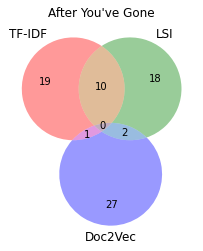

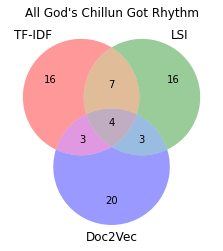

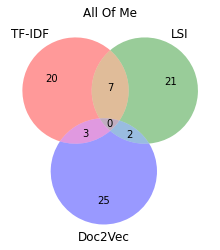

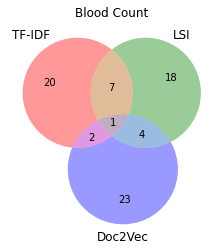

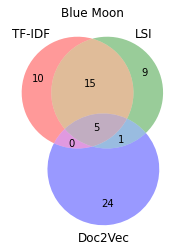

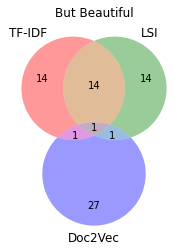

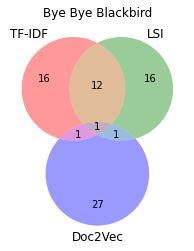

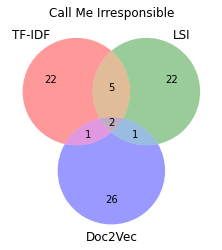

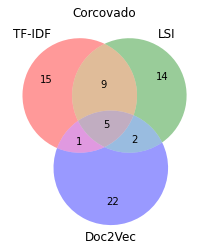

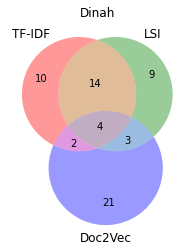

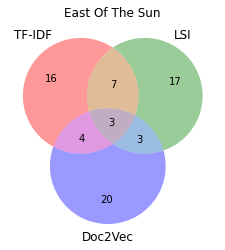

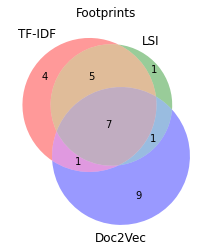

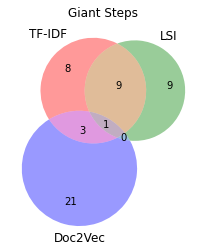

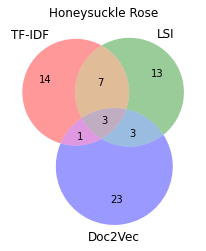

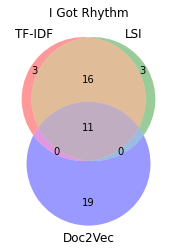

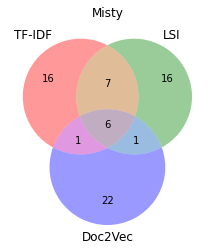

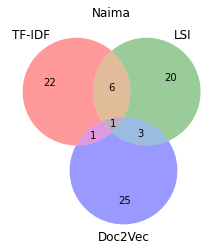

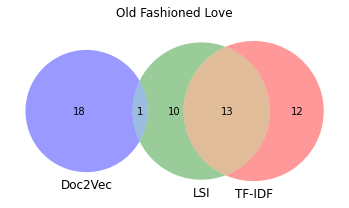

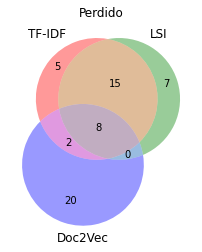

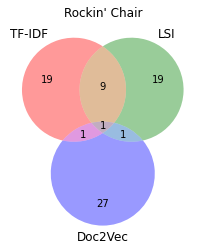

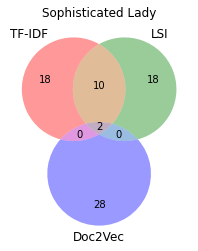

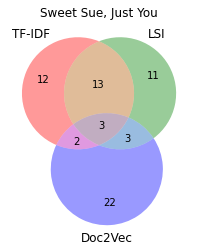

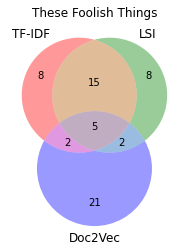

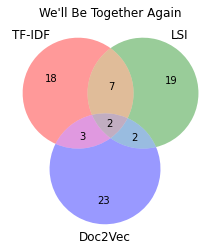

In [95]:
for tune in tunes_eval_list:
  df, details = recommend_tune(df_tfidf, tune)
  tfidf_tunes = list(df.head(30).loc[:,'similar_title'])

  df, details = recommend_tune(df_lsi, tune)
  lsi_tunes = list(df.head(30).loc[:,'similar_title'])

  df, details = recommend_tune(df_word2vec, tune)
  word2vec_tunes = list(df.head(30).loc[:,'similar_title'])

  set_tfidf = set(tfidf_tunes)
  set_lsi = set(lsi_tunes)
  set_word2vec = set(word2vec_tunes)

  venn3([set_tfidf, set_lsi, set_word2vec], 
        set_labels=('TF-IDF', 'LSI', 'Doc2Vec'),
        )
  plt.title(f"{tune}")
  plt.savefig('plot.png')
  wandb.log({"venn_methods": wandb.Image('plot.png')})
  plt.show()

# W&B Logging and Finish

In [96]:
recommender_results

,reference,id,method,similar,score_div_max,score
0,We'll Be Together Again,0.0,tfidf,Don't Know Why,1.000000,0.281678
1,We'll Be Together Again,1.0,tfidf,Street Of Dreams,1.000000,0.422561
2,We'll Be Together Again,2.0,tfidf,Don't Blame Me,0.913268,0.257248
3,We'll Be Together Again,3.0,tfidf,Straight Street,0.890178,0.250744
4,We'll Be Together Again,4.0,tfidf,Goodbye,0.821184,0.347000
...,...,...,...,...,...,...
58,We'll Be Together Again,NaN,doc2vec,NaN,NaN,NaN
59,We'll Be Together Again,NaN,doc2vec,NaN,NaN,NaN
60,We'll Be Together Again,NaN,doc2vec,NaN,NaN,NaN
61,We'll Be Together Again,NaN,doc2vec,NaN,NaN,NaN


In [97]:
recommender_results = recommender_results.reset_index()

results = recommender_results.pivot(index=['index', 'reference', 'similar'], columns='method', values=['id', 'score', 'score_div_max'])
results.columns = ['_'.join(col) for col in results.columns]
results = results.reset_index()
results

,index,reference,similar,id_doc2vec,id_lsi,id_tfidf,score_doc2vec,score_lsi,score_tfidf,score_div_max_doc2vec,score_div_max_lsi,score_div_max_tfidf
0,0,We'll Be Together Again,Begin The Beguine,0.0,0.0,NaN,0.785531,0.785531,NaN,1.00000,1.00000,NaN
1,0,We'll Be Together Again,Don't Know Why,NaN,NaN,0.0,NaN,NaN,0.281678,NaN,NaN,1.000000
2,1,We'll Be Together Again,Street Of Dreams,1.0,1.0,1.0,0.928580,0.928580,0.422561,1.00000,1.00000,1.000000
3,2,We'll Be Together Again,Darn That Dream,2.0,2.0,NaN,0.749341,0.749341,NaN,0.96297,0.96297,NaN
4,2,We'll Be Together Again,Don't Blame Me,NaN,NaN,2.0,NaN,NaN,0.257248,NaN,NaN,0.913268
...,...,...,...,...,...,...,...,...,...,...,...,...
99,58,We'll Be Together Again,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,59,We'll Be Together Again,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,60,We'll Be Together Again,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,61,We'll Be Together Again,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
table = wandb.Table(dataframe=results)
wandb.log({"recommender results": results})

In [99]:
wandb.finish()